In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold

In [2]:
cols = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type",
        "Vehicle Style", "highway MPG", "city mpg", "MSRP"]
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
df = pd.read_csv(url, usecols=cols)

In [3]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

In [4]:
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [5]:
df["engine_hp"].fillna(value=0, inplace=True)
df["engine_cylinders"].fillna(value=0, inplace=True)

In [6]:
df.rename(columns = {'msrp':'price'}, inplace = True)

In [7]:
mean = df["price"].mean()
df["above_average"] = np.where(df["price"]>=mean, 1, 0)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [8]:
dff = df.copy()
df = df.drop("price", axis=1)

In [9]:
dff_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(dff_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["above_average"]
y_val = df_val["above_average"]
y_test = df_test["above_average"]

del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

In [10]:
num_cols = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [11]:
for col in num_cols:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print(f'{col}: auc={round(auc,3)}')

engine_hp: auc=0.917
engine_cylinders: auc=0.766
highway_mpg: auc=0.633
city_mpg: auc=0.673


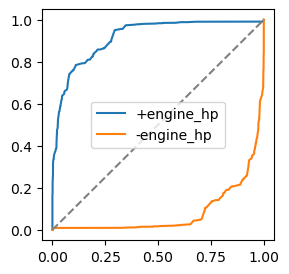

In [12]:
# Plotting the ROC curve
plt.figure(figsize=(3, 3))

fpr, tpr, _ = roc_curve(y_train, df_train["engine_hp"])
plt.plot(fpr, tpr, label='+engine_hp')

fpr, tpr, _ = roc_curve(y_train, -df_train["engine_hp"])
plt.plot(fpr, tpr, label='-engine_hp')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [13]:
all_cols = df_train.columns.to_list()
all_cols

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [14]:
['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [15]:
# Dictionary for the df_train set
train_dicts = df_train[all_cols].to_dict(orient='records')

# Apply One-hot encoding to X_train
dv = DictVectorizer(sparse=False)
df_train_oh = dv.fit_transform(train_dicts)

In [16]:
# Instantiate and Fit the Model over X_train_oh
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(df_train_oh, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [17]:
# Apply One-hot encoding to X_val
val_dicts = df_val[all_cols].to_dict(orient='records')
df_val_oh = dv.transform(val_dicts)

# Predict Values with 'model' on X_val_oh
y_pred = model.predict_proba(df_val_oh)[:, 1]

In [18]:
# ROC AUC score:
roc = roc_auc_score(y_val, y_pred)
round(roc,3)

0.977

In [19]:
# Creating Confusion Matrix:
def confusion_matrix_df(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


# Use of the functions
df_scores = confusion_matrix_df(y_val, y_pred)
df_scores[::10]     

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,643,345,11,1384
20,0.2,622,218,32,1511
30,0.3,606,159,48,1570
40,0.4,588,109,66,1620
50,0.5,567,76,87,1653
60,0.6,522,49,132,1680
70,0.7,490,36,164,1693
80,0.8,440,17,214,1712
90,0.9,347,4,307,1725


In [20]:
# Add column 'p' (precision) and 'r' (recall)
df_scores["p"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["r"] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [21]:
# Filter df_scores by the difference between 'p' & 'r'
df_scores[abs(df_scores["p"] - df_scores["r"]) < 0.01]

,threshold,tp,fp,fn,tn,p,r
47,0.47,573,87,81,1642,0.868182,0.876147
48,0.48,570,87,84,1642,0.867580,0.871560
49,0.49,567,80,87,1649,0.876352,0.866972


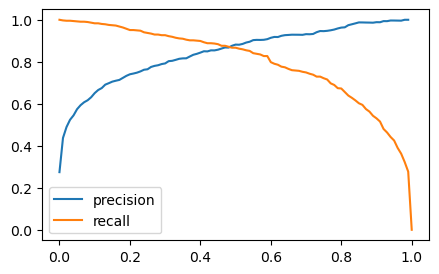

In [22]:
# Plot the curves
plt.figure(figsize=(5, 3))

plt.plot(df_scores["threshold"], df_scores["p"], label='precision')
plt.plot(df_scores["threshold"], df_scores["r"], label='recall')

plt.legend()

In [23]:
# Calculate F1 scores
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

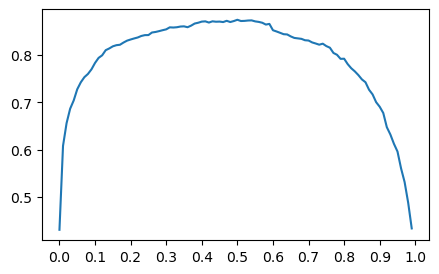

In [24]:
# Plot F1 score
plt.figure(figsize=(5,3))
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [25]:
df_scores.sort_values(by="f1",ascending=False).head()

,threshold,tp,fp,fn,tn,p,r,f1
50,0.50,567,76,87,1653,0.881804,0.866972,0.874325
54,0.54,557,65,97,1664,0.895498,0.851682,0.873041
53,0.53,559,68,95,1661,0.891547,0.854740,0.872756
47,0.47,573,87,81,1642,0.868182,0.876147,0.872146
52,0.52,562,73,92,1656,0.885039,0.859327,0.871994


In [26]:
def train(df_train, y_train, C=1.0):
    train_dicts = df_train[all_cols].to_dict(orient='records')

    dv_kf = DictVectorizer(sparse=False)
    X_train = dv_kf.fit_transform(train_dicts)

    model_kf = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model_kf.fit(X_train, y_train)

    return dv_kf, model_kf

def predict(df, dv, model):
    pred_dicts = df[all_cols].to_dict(orient='records')

    X = dv.transform(pred_dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [27]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(dff_train):
    df_train_kf = dff_train.iloc[train_idx]
    df_val_kf = dff_train.iloc[val_idx]

    y_train_kf = df_train_kf["above_average"]
    y_val_kf = df_val_kf["above_average"]

    dv_kf, model_kf = train(df_train_kf, y_train_kf, C=1.0)
    y_pred_kf = predict(df_val_kf, dv_kf, model_kf)

    auc_sc = roc_auc_score(y_val_kf, y_pred_kf)
    scores.append(auc_sc)

print(f'auc={round(np.mean(scores),4)}, std={round(np.std(scores),4)}')

auc=0.9792, std=0.0029


In [28]:
# KFold with differnte values for C
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(dff_train):
        df_train = dff_train.iloc[train_idx]
        df_val = dff_train.iloc[val_idx]

        y_train = df_train["above_average"]
        y_val = df_val["above_average"]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc_sc = roc_auc_score(y_val, y_pred)
        scores.append(auc_sc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.972 +- 0.002
C=   1, 0.979 +- 0.003
C=  10, 0.981 +- 0.003
